In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import shutil
import glob
import io
import os
import pathlib


In [9]:
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [11]:
#dataset from Roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="YHTjnmxe3lRU4B3THhhe")
project = rf.workspace("c-zef0o").project("damaged-vehicle-images-euqbx")
version = project.version(1)
dataset = version.download("folder")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Damaged-Vehicle-Images-1 in folder:: 100%|██████████| 5160/5160 [00:05<00:00, 998.85it/s] 


##### Create a dataset



In [30]:
data_dir = pathlib.Path("./Damaged-Vehicle-Images-1/train")



batch_size = 32
img_height = 180
img_width  = 180


train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",         
    label_mode="int",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 4058 files belonging to 30 classes.


In [31]:
print("Classes:", train_ds.class_names)


Classes: ['crack_and_hole', 'crack_and_hole medium_deformation', 'crack_and_hole medium_deformation severe_scratch', 'crack_and_hole severe_deformation', 'crack_and_hole severe_deformation severe_scratch', 'crack_and_hole severe_scratch', 'crack_and_hole severe_scratch slight_scratch', 'crack_and_hole slight_deformation', 'crack_and_hole slight_scratch', 'crack_and_hole windshield_damage', 'medium_deformation', 'medium_deformation severe_deformation', 'medium_deformation severe_scratch', 'medium_deformation severe_scratch slight_scratch', 'medium_deformation slight_deformation', 'medium_deformation slight_scratch', 'severe_deformation', 'severe_deformation severe_scratch', 'severe_deformation severe_scratch slight_scratch', 'severe_deformation slight_scratch', 'severe_deformation windshield_damage', 'severe_scratch', 'severe_scratch slight_deformation', 'severe_scratch slight_deformation slight_scratch', 'severe_scratch slight_scratch', 'severe_scratch windshield_damage', 'slight_defor

In [32]:
class_names = train_ds.class_names


In [33]:
num_classes = len(class_names)
print(class_names)

['crack_and_hole', 'crack_and_hole medium_deformation', 'crack_and_hole medium_deformation severe_scratch', 'crack_and_hole severe_deformation', 'crack_and_hole severe_deformation severe_scratch', 'crack_and_hole severe_scratch', 'crack_and_hole severe_scratch slight_scratch', 'crack_and_hole slight_deformation', 'crack_and_hole slight_scratch', 'crack_and_hole windshield_damage', 'medium_deformation', 'medium_deformation severe_deformation', 'medium_deformation severe_scratch', 'medium_deformation severe_scratch slight_scratch', 'medium_deformation slight_deformation', 'medium_deformation slight_scratch', 'severe_deformation', 'severe_deformation severe_scratch', 'severe_deformation severe_scratch slight_scratch', 'severe_deformation slight_scratch', 'severe_deformation windshield_damage', 'severe_scratch', 'severe_scratch slight_deformation', 'severe_scratch slight_deformation slight_scratch', 'severe_scratch slight_scratch', 'severe_scratch windshield_damage', 'slight_deformation', 

#### Visualise the dataset

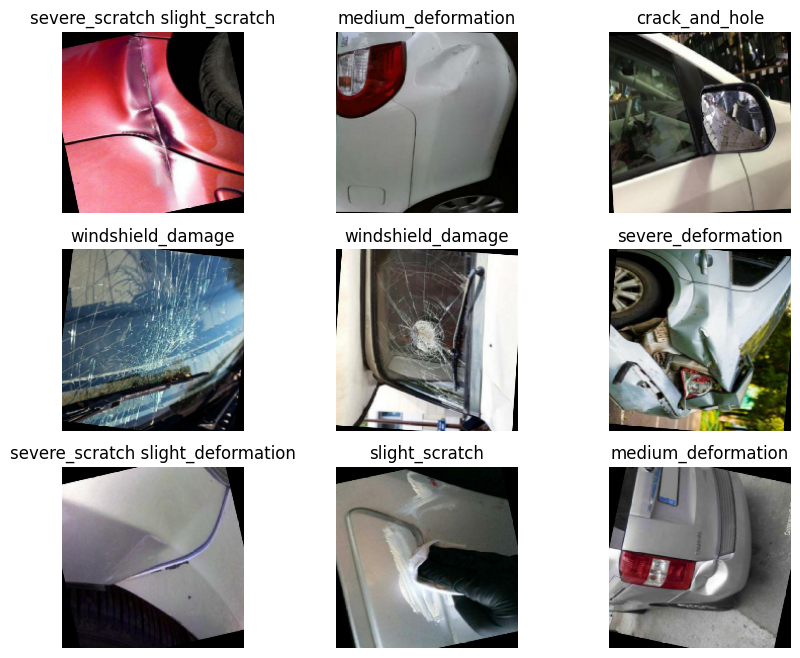

In [17]:
plt.figure(figsize=(10, 8))
for images, labels in train_ds.take(1):  # pega só o primeiro batch
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")
plt.show()

In [20]:
data_path = pathlib.Path("./Damaged-Vehicle-Images-1/valid")

In [21]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    labels="inferred",          
    label_mode="int",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 507 files belonging to 27 classes.


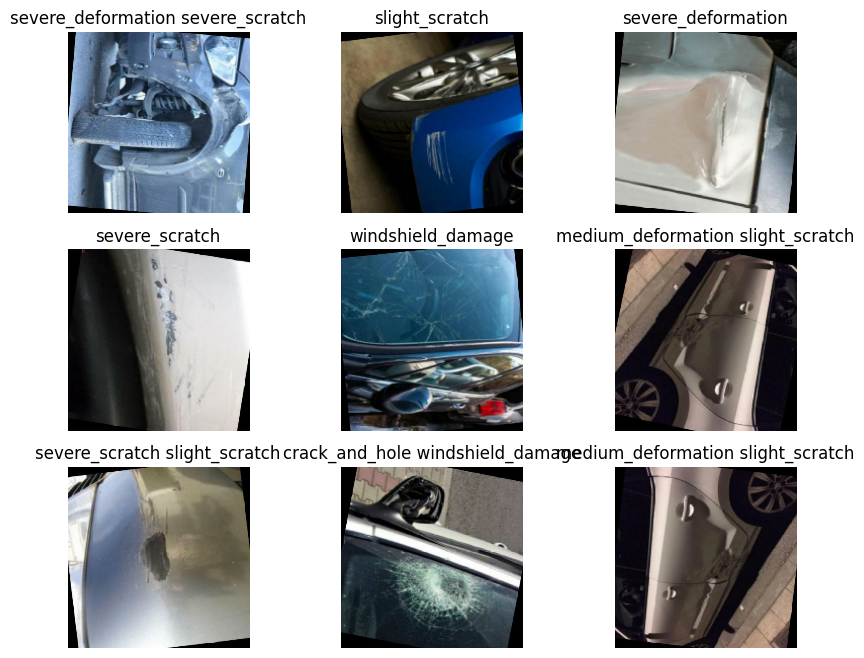

In [22]:
plt.figure(figsize=(10, 8))
for images, labels in val_ds.take(1): 
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(val_ds.class_names[labels[i]])
        plt.axis("off")
plt.show()

#### * `Dataset.cache` keeps the images in memory after they are loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model.
#### * `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [34]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Data Augmentation

In [35]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

#### Visualize a few augmented examples by applying data augmentation to the same image several times:

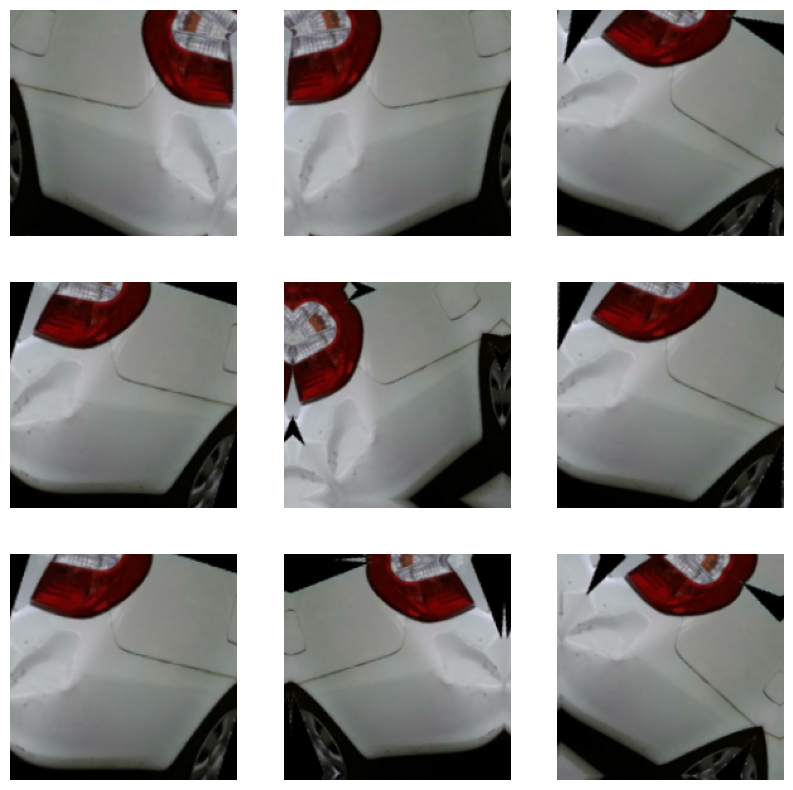

In [36]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Model

In [37]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation, # layer of data augmentation
  layers.Rescaling(1./255), # standardize data
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), # dropout layer
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

#### Compile the model

We will use the Adam optimizer `tf.keras.optimizers.Adam` and as loss function the cross entropy `tf.keras.losses.SparseCategoricalCrossentropy`. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.


In [38]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [42]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,977,532 (45.69 MB)

 Trainable params: 3,992,510 (15.23 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,985,022 (30.46 MB)

#### Train the model

Train the model for 15 epochs with the Keras `Model.fit` method:

In [40]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.1996 - loss: 2.5946 - val_accuracy: 0.0611 - val_loss: 4.8675
Epoch 2/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - accuracy: 0.3400 - loss: 2.1877 - val_accuracy: 0.0237 - val_loss: 5.3082
Epoch 3/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - accuracy: 0.3728 - loss: 2.0320 - val_accuracy: 0.0473 - val_loss: 6.1345
Epoch 4/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - accuracy: 0.3952 - loss: 1.9198 - val_accuracy: 0.0434 - val_loss: 6.3110
Epoch 5/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.4302 - loss: 1.7679 - val_accuracy: 0.0690 - val_loss: 6.3910
Epoch 6/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.4721 - loss: 1.6535 - val_accuracy: 0.0513 - val_loss: 6.1690
Epoch 7/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.5181 - loss: 1.5226 - val_accuracy: 0.0552 - val_loss: 8.3780
Epoch 8/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 0.5220 - loss: 1

#### Visualise training results

Create plots of the loss and accuracy on the training and validation sets:

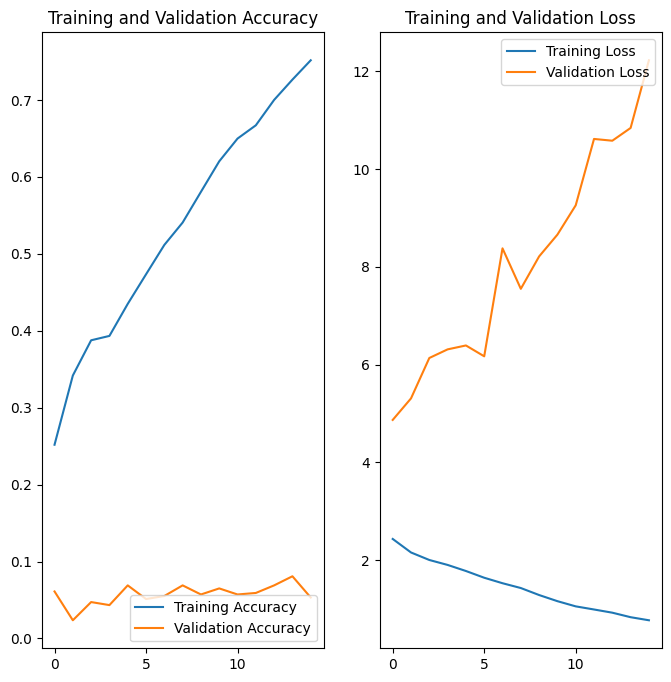

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()